<a href="https://colab.research.google.com/github/Sagramine/ScraptKomenIG/blob/main/Scrapt_Komentar_dan_3_Model_Sentiment_Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SCRAPT KOMENTAR INSTAGRAM**

In [ ]:
# @title Setting DNS

!echo "nameserver 1.1.1.1" | sudo tee /etc/resolv.conf
!echo "nameserver 1.0.0.1" | sudo tee -a /etc/resolv.conf

In [ ]:
# @title Instagram API Wrapper
!pip install instagrapi pandas

In [ ]:
# @title Update API Jika ada
!pip install --upgrade instagrapi

In [ ]:
# @title **Import Libraries dan Modules**
from instagrapi import Client
import pandas as pd
from getpass import getpass
from instagrapi.exceptions import TwoFactorRequired, LoginRequired
from getpass import getpass
import time
import random
import os

In [ ]:
# @title **Login Akun Instagram dan Atur Session**
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

USERNAME = input("Masukkan username Instagram Anda: ")
PASSWORD = getpass("Masukkan password Instagram Anda: ")

# Inisialisasi client
cl = Client()

# Nama file untuk menyimpan sesi di Google Drive
session_file = f"/content/drive/MyDrive/{USERNAME}_session.json"

# Simpan sesi
def save_session(client):
    client.dump_settings(session_file)

# Memuat sesi yang sudah dibuat sebelumnya
def load_session(client):
    if os.path.exists(session_file):
        client.load_settings(session_file)
        return True
    return False

# Percobaan Load sesi yang sudah ada, jika belum login ulang
if load_session(cl):
    try:
        cl.get_timeline_feed()
        print(f"\nBerhasil login menggunakan sesi yang disimpan sebagai: {USERNAME}")
    except Exception as e:
        print("Sesi tidak valid, login ulang...")
        # Jika sesi tidak valid, hapus file sesi dan login ulang
        os.remove(session_file)
        cl = Client()
else:
    print("Tidak ada sesi yang tersimpan, melakukan login...")

# Coba login, jika membutuhkan autentikasi dua faktor, minta kode dari pengguna
try:
    cl.login(USERNAME, PASSWORD)
    save_session(cl)  # Menyimpan sesi setelah login berhasil
    # Verifikasi apakah file sesi disimpan
    if os.path.exists(session_file):
        print(f"\nBerhasil login sebagai: {cl.account_info().username}")
        print(f"File sesi berhasil disimpan di Google Drive: {session_file}")
    else:
        print(f"\nBerhasil login sebagai: {cl.account_info().username}")
        print("Gagal menyimpan file sesi di Google Drive.")
except TwoFactorRequired:
    two_factor_code = input("Masukkan kode autentikasi dua faktor Anda: ")
    cl.login(USERNAME, PASSWORD, verification_code=two_factor_code)
    save_session(cl)  # Menyimpan sesi setelah login berhasil
    # Verifikasi apakah file sesi disimpan
    if os.path.exists(session_file):
        print(f"\nBerhasil login dengan autentikasi dua faktor sebagai: {cl.account_info().username}")
        print(f"File sesi berhasil disimpan di Google Drive: {session_file}")
    else:
        print(f"\nBerhasil login dengan autentikasi dua faktor sebagai: {cl.account_info().username}")
        print("Gagal menyimpan file sesi di Google Drive.")
except Exception as e:
    print(f"Terjadi kesalahan saat login: {e}")

In [ ]:
# @title **Menentukan Fungsi untuk Mengambil Komentar dari Postingan**

def get_comments_and_caption(url, max_comments=110):
    try:
        # Dapatkan media dari URL
        media_pk = cl.media_pk_from_url(url)

        # Ambil informasi media termasuk caption
        media_info = cl.media_info(media_pk)
        caption_text = media_info.caption_text if media_info.caption_text else ""

        # Ambil komentar
        comments = cl.media_comments(media_pk, amount=max_comments)

        # Format data
        comments_data = []
        try:
            for c in comments:
                comments_data.append({
                    'post_caption': caption_text,
                    'username': c.user.username,
                    'profile_url': f"https://instagram.com/{c.user.username}",
                    'comment': c.text,
                    'likes': c.like_count,
                    'timestamp': c.created_at_utc.strftime('%Y-%m-%d %H:%M:%S')
                })
                waktu_tunda = random.uniform(0.5, 1.5)
                print(f"Menunggu selama {waktu_tunda:.2f} detik...")
                time.sleep(waktu_tunda)
            return comments_data

        except Exception as e:
            print(f"Terjadi kesalahan saat memproses komentar: {e.__class__.__name__} - {str(e)}")
            return []

    except Exception as e:
        print(f"Terjadi kesalahan: {e.__class__.__name__} - {str(e)}")
        return []

# Fungsi untuk mendapatkan shortlink dari URL
def get_shortlink(url):
    # Menghapus '/' di awal dan akhir URL jika ada
    url = url.strip('/')
    # Memecah URL menjadi bagian-bagian
    parts = url.split('/')
    # Shortlink biasanya ada di indeks terakhir
    return parts[-1]

In [ ]:
# @title **Atur URL, Jumlah Komentar, dan Hasil**
from google.colab import files

post_urls = []
shortlinks = []

while True:
    url = input("\nMasukkan URL postingan Instagram (atau ketik 'selesai'): ").strip()
    if url.lower() == 'selesai':
        break
    if '/p/' not in url and '/reel/' not in url:
        print("URL tidak valid! Harus mengandung '/p/' atau '/reel/'")
        continue
    post_urls.append(url)
    # Mendapatkan shortlink
    shortlink = get_shortlink(url)
    shortlinks.append(shortlink)

if not post_urls:
    print("Tidak ada URL yang dimasukkan!")
    exit()

# Input jumlah maksimal komentar per post
while True:
    try:
        max_comments = int(input("\nMasukkan jumlah maksimal komentar per post: "))
        if max_comments > 0:
            break
        else:
            print("Jumlah maksimal komentar harus lebih dari 0.")
    except ValueError:
        print("Mohon masukkan angka yang valid.")

# Proses setiap URL
for idx, (url, shortlink) in enumerate(zip(post_urls, shortlinks)):
    print(f"\nMemproses: {url}")
    comments = get_comments_and_caption(url, max_comments)
    print(f"Jumlah komentar yang dikumpulkan: {len(comments)}")

    if comments:
        df = pd.DataFrame(comments)

        # Konversi tipe data
        df['likes'] = pd.to_numeric(df['likes'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Sorting data
        df = df.sort_values(by=['likes', 'timestamp'], ascending=[False, False])

        # Simpan ke CSV dengan nama file menggunakan shortlink
        filename = f"ig_comments_{shortlink}.csv"
        df.to_csv(filename, index=False)

        # Informasi postingan
        try:
            media_pk = cl.media_pk_from_url(url)
            media_info = cl.media_info(media_pk)
            total_post_likes = media_info.like_count
            total_post_comments = media_info.comment_count
            post_link = url  # Link postingan

            # Tambahkan total likes, total comments, dan link postingan di akhir CSV
            with open(filename, 'a', newline='', encoding='utf-8') as f:
                f.write('\n')  # Tambahkan baris kosong
                f.write(f"Total Post Likes,{total_post_likes}\n")
                f.write(f"Total Post Comments,{total_post_comments}\n")
                f.write(f"Post URL,{post_link}\n")

        except Exception as e:
            print(f"Terjadi kesalahan saat mengambil informasi postingan: {e.__class__.__name__} - {str(e)}")

        # Unduh file
        try:
            files.download(filename)
            print(f"\nFile berhasil disimpan dan diunduh: {filename}")
        except Exception as e:
            print(f"Gagal mengunduh file {filename}: {e}")

        print("\nPreview Data:")
        print(df.head())
    else:
        print("\nTidak ada komentar yang berhasil dikumpulkan untuk URL ini.")

    # Cek apakah masih ada URL berikutnya
    if idx < len(post_urls) - 1:
        # Waktu tunda acak antara 3 hingga 5 detik
        waktu_tunda = random.uniform(4, 8)
        print(f"\nMenunggu selama {waktu_tunda:.2f} detik sebelum memproses URL berikutnya...")
        time.sleep(waktu_tunda)
    else:
        print("\nSemua URL telah diproses.")


Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/C_uosx1yYdQ

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/C_w8v8BJLIi

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/C_xdS42TpNn

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/DAIUcSzyn9J

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/DAPlqz9Jp1M

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/DBFcqQVy5zz

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/DBU5cJKSPMK

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/DBWQWe2SWtv

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/DBiBDhxTBfn

Masukkan URL postingan Instagram (atau ketik 'selesai'): https://www.instagram.com/p/DBtIxOWS95G

Masukkan URL postin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_C_uosx1yYdQ.csv

Preview Data:
                                         post_caption         username  \
80  Dalam rangka mewujudkan Indonesia Digital 2045...    ajwaramadhana   
99  Dalam rangka mewujudkan Indonesia Digital 2045...        mulyon_oo   
89  Dalam rangka mewujudkan Indonesia Digital 2045...        ichbindah   
97  Dalam rangka mewujudkan Indonesia Digital 2045...  vendikurniawan_   
85  Dalam rangka mewujudkan Indonesia Digital 2045...      yusufcupopp   

                              profile_url  \
80    https://instagram.com/ajwaramadhana   
99        https://instagram.com/mulyon_oo   
89        https://instagram.com/ichbindah   
97  https://instagram.com/vendikurniawan_   
85      https://instagram.com/yusufcupopp   

                                              comment  likes  \
80  Ibu Hamil di luar lingkungan istana yang serba...     62   
99       Cebokin terus, siapa tau jadi menteri lagi 😂     38   
89  Pak Budi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_C_w8v8BJLIi.csv

Preview Data:
                                         post_caption       username  \
99  Halo Sobatkom! Pernahkah kalian menerima video...       dztajbrl   
39  Halo Sobatkom! Pernahkah kalian menerima video...      mh2harris   
40  Halo Sobatkom! Pernahkah kalian menerima video...  joemuhamad182   
83  Halo Sobatkom! Pernahkah kalian menerima video...       aabinowo   
6   Halo Sobatkom! Pernahkah kalian menerima video...       rradiiba   

                            profile_url  \
99       https://instagram.com/dztajbrl   
39      https://instagram.com/mh2harris   
40  https://instagram.com/joemuhamad182   
83       https://instagram.com/aabinowo   
6        https://instagram.com/rradiiba   

                                              comment  likes  \
99  @andikamarg sumpah lawak banget ya 😂 ada mente...      6   
39  Suruh mundur aja bapak itu min, gak berkompete...      2   
40                Kalo nomor private

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_C_xdS42TpNn.csv

Preview Data:
                                         post_caption      username  \
98  Halo Sobatkom! 📢 Pendaftaran CPNS 2024 di Keme...        synov_   
96  Halo Sobatkom! 📢 Pendaftaran CPNS 2024 di Keme...  littledegres   
44  Halo Sobatkom! 📢 Pendaftaran CPNS 2024 di Keme...    syasyaa.ns   
89  Halo Sobatkom! 📢 Pendaftaran CPNS 2024 di Keme...   bayu_adji29   
22  Halo Sobatkom! 📢 Pendaftaran CPNS 2024 di Keme...        synov_   

                           profile_url  \
98        https://instagram.com/synov_   
96  https://instagram.com/littledegres   
44    https://instagram.com/syasyaa.ns   
89   https://instagram.com/bayu_adji29   
22        https://instagram.com/synov_   

                                              comment  likes  \
98  Min @kemenkominfo kapan di rilis ini hasil sel...      6   
96                    Kominfo pengumannya di mana ya?      4   
44  @mr.tilee apakah sudah ada informasi lanjut?

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DAIUcSzyn9J.csv

Preview Data:
                                         post_caption         username  \
92  Kabar Gembira, #SahabatFrekuensi!\nDirektorat ...        f4_irawan   
81  Kabar Gembira, #SahabatFrekuensi!\nDirektorat ...         ridsep__   
86  Kabar Gembira, #SahabatFrekuensi!\nDirektorat ...  fajar_alifirman   
82  Kabar Gembira, #SahabatFrekuensi!\nDirektorat ...           kcz_25   
88  Kabar Gembira, #SahabatFrekuensi!\nDirektorat ...   djoko_simbolon   

                              profile_url  \
92        https://instagram.com/f4_irawan   
81         https://instagram.com/ridsep__   
86  https://instagram.com/fajar_alifirman   
82           https://instagram.com/kcz_25   
88   https://instagram.com/djoko_simbolon   

                                              comment  likes  \
92  Serius tanya, ini jobdesk menterinya ganti jd ...     35   
81  Kebanyakan penghargaan sampai lupa data warga ...     29   
86  Heiii ju

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DAPlqz9Jp1M.csv

Preview Data:
                                         post_caption       username  \
56  Sobatkom, Menkominfo Budi Arie Setiadi bersama...    gendarpcel_   
64  Sobatkom, Menkominfo Budi Arie Setiadi bersama...      welly_801   
92  Sobatkom, Menkominfo Budi Arie Setiadi bersama...  rinaldybergas   
79  Sobatkom, Menkominfo Budi Arie Setiadi bersama...   mhaidaranass   
15  Sobatkom, Menkominfo Budi Arie Setiadi bersama...       exiwkyoo   

                            profile_url  \
56    https://instagram.com/gendarpcel_   
64      https://instagram.com/welly_801   
92  https://instagram.com/rinaldybergas   
79   https://instagram.com/mhaidaranass   
15       https://instagram.com/exiwkyoo   

                                              comment  likes  \
56                   Scroll komen nyari komen positif     22   
64  3 hal yang ga boleh di lewatkan setiap hari\n-...     22   
92  Pemain Overwatch apakah anda sud

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DBFcqQVy5zz.csv

Preview Data:
                                         post_caption       username  \
82  Halo, SobatKom!\n\nKementerian Komunikasi dan ...    _oktamelias   
68  Halo, SobatKom!\n\nKementerian Komunikasi dan ...  bljrbersamaku   
79  Halo, SobatKom!\n\nKementerian Komunikasi dan ...    _oktamelias   
43  Halo, SobatKom!\n\nKementerian Komunikasi dan ...      dtstsa.id   
75  Halo, SobatKom!\n\nKementerian Komunikasi dan ...    co_______le   

                            profile_url  \
82    https://instagram.com/_oktamelias   
68  https://instagram.com/bljrbersamaku   
79    https://instagram.com/_oktamelias   
43      https://instagram.com/dtstsa.id   
75    https://instagram.com/co_______le   

                                              comment  likes  \
82  kok kartu ujian gabisa ke loading atau di down...      7   
68  mimin kok kartu ujiannya gak bisa didownload y...      4   
79  @firman_almzfr_96 di aku whitela

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DBU5cJKSPMK.csv

Preview Data:
                                         post_caption       username  \
11  10 Tahun lalu, perjalanan besar telah dimulai....    analia_nesa   
31  10 Tahun lalu, perjalanan besar telah dimulai....  mei_silitonga   
69  10 Tahun lalu, perjalanan besar telah dimulai....    rpranadiiii   
79  10 Tahun lalu, perjalanan besar telah dimulai....       ari3.win   
17  10 Tahun lalu, perjalanan besar telah dimulai....    methania_22   

                            profile_url  \
11    https://instagram.com/analia_nesa   
31  https://instagram.com/mei_silitonga   
69    https://instagram.com/rpranadiiii   
79       https://instagram.com/ari3.win   
17    https://instagram.com/methania_22   

                                              comment  likes  \
11  Terima kasih bapak Jokowi, sudah banyak berjas...      2   
31  @dheniz666 : Kamiii ? Maksudnya Lu & Para Pemb...      2   
69                         @_devdrea

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DBWQWe2SWtv.csv

Preview Data:
                                         post_caption      username  \
73  Halo, SobatKom!\n\nMinfo mau ngucapin terima k...       amz_san   
62  Halo, SobatKom!\n\nMinfo mau ngucapin terima k...     doraemot1   
66  Halo, SobatKom!\n\nMinfo mau ngucapin terima k...  markuskokonb   
64  Halo, SobatKom!\n\nMinfo mau ngucapin terima k...     denadamay   
50  Halo, SobatKom!\n\nMinfo mau ngucapin terima k...       suketzy   

                           profile_url  \
73       https://instagram.com/amz_san   
62     https://instagram.com/doraemot1   
66  https://instagram.com/markuskokonb   
64     https://instagram.com/denadamay   
50       https://instagram.com/suketzy   

                                              comment  likes  \
73  Semoga kedepannya, pengganti BUDI bukan fokus ...     53   
62  Budi Arie Set.. nggak jadi menteri Kominfo lag...     23   
66                          Noh dikasih Bu Mutia

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DBiBDhxTBfn.csv

Preview Data:
                                         post_caption     username  \
51  Halo Sobatkom! Kamis (24/10), Menteri Komunika...     dege.knw   
55  Halo Sobatkom! Kamis (24/10), Menteri Komunika...   dhimaspnps   
18  Halo Sobatkom! Kamis (24/10), Menteri Komunika...   ahsinil.aa   
25  Halo Sobatkom! Kamis (24/10), Menteri Komunika...  fardhan_zal   
53  Halo Sobatkom! Kamis (24/10), Menteri Komunika...  rama_sejati   

                          profile_url  \
51     https://instagram.com/dege.knw   
55   https://instagram.com/dhimaspnps   
18   https://instagram.com/ahsinil.aa   
25  https://instagram.com/fardhan_zal   
53  https://instagram.com/rama_sejati   

                                              comment  likes  \
51   Udah berapa % progres pemberantasan judi online?     22   
55                          PR: Jaminan Keamanan Data     20   
18  @dege.knw ini adlh salah satu pertanyaan dr kl...     12

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DBtIxOWS95G.csv

Preview Data:
                                        post_caption                username  \
2  Menkomdigi menerima audiensi Duta Besar Austra...        lembagapenyiaran   
7  Menkomdigi menerima audiensi Duta Besar Austra...                ambari49   
8  Menkomdigi menerima audiensi Duta Besar Austra...  ____a.dayu.swastika331   
9  Menkomdigi menerima audiensi Duta Besar Austra...           htler.come.in   
0  Menkomdigi menerima audiensi Duta Besar Austra...             faiz.risky_   

                                    profile_url  \
2        https://instagram.com/lembagapenyiaran   
7                https://instagram.com/ambari49   
8  https://instagram.com/____a.dayu.swastika331   
9           https://instagram.com/htler.come.in   
0             https://instagram.com/faiz.risky_   

                                             comment  likes  \
2                                  oke mantap ibu RI      1   
7     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCBPyKNp20x.csv

Preview Data:
                                         post_caption        username  \
48  Sobatkom, Menkomdigi Meutya Hafid bersama Ment...  dosen_gamer.id   
44  Sobatkom, Menkomdigi Meutya Hafid bersama Ment...  amezi_lovazian   
43  Sobatkom, Menkomdigi Meutya Hafid bersama Ment...     belvahendry   
52  Sobatkom, Menkomdigi Meutya Hafid bersama Ment...       noerrr93_   
27  Sobatkom, Menkomdigi Meutya Hafid bersama Ment...          zkyy7_   

                             profile_url  \
48  https://instagram.com/dosen_gamer.id   
44  https://instagram.com/amezi_lovazian   
43     https://instagram.com/belvahendry   
52       https://instagram.com/noerrr93_   
27          https://instagram.com/zkyy7_   

                                              comment  likes  \
48  Akhirnya ni akun posting aktifitas kementerian...     37   
44           Menlu nya gg kalah keren dri yg kemaren🔥     17   
43               ini pim

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCDr9nJSmnO.csv

Preview Data:
                                         post_caption          username  \
58  Halo, SobatKom!\n\nMenkomdigi Meutya Hafid men...           jay.btr   
74  Halo, SobatKom!\n\nMenkomdigi Meutya Hafid men...  luthfi.landscape   
68  Halo, SobatKom!\n\nMenkomdigi Meutya Hafid men...       miilaamalia   
72  Halo, SobatKom!\n\nMenkomdigi Meutya Hafid men...       chriss__t_0   
75  Halo, SobatKom!\n\nMenkomdigi Meutya Hafid men...         kasep2703   

                               profile_url  \
58           https://instagram.com/jay.btr   
74  https://instagram.com/luthfi.landscape   
68       https://instagram.com/miilaamalia   
72       https://instagram.com/chriss__t_0   
75         https://instagram.com/kasep2703   

                                              comment  likes  \
58  Ini akun resmi kementerian tapi isinya hanya s...     48   
74  @kasep2703 objektif aja, sudah benar, salah sa...     47   


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCGicDyyLrQ.csv

Preview Data:
                                         post_caption      username  \
10  Halo, SobatKom!\n\nPada hari Kamis (7/11/2024)...  muh_anwar_ld   
12  Halo, SobatKom!\n\nPada hari Kamis (7/11/2024)...      _rryotaa   
3   Halo, SobatKom!\n\nPada hari Kamis (7/11/2024)...       la.boer   
14  Halo, SobatKom!\n\nPada hari Kamis (7/11/2024)...    lq_______m   
2   Halo, SobatKom!\n\nPada hari Kamis (7/11/2024)...    atenkvindy   

                           profile_url  \
10  https://instagram.com/muh_anwar_ld   
12      https://instagram.com/_rryotaa   
3        https://instagram.com/la.boer   
14    https://instagram.com/lq_______m   
2     https://instagram.com/atenkvindy   

                                              comment  likes  \
10  Tolong ditindak lanjuti, makin banyak iklan ju...      8   
12  Pak coba deh liat akun mpl Indonesia di TikTok...      3   
3   Situs judol yg manakah sebenarnya yg telah d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCJjPOxzTqF.csv

Preview Data:
                                         post_caption               username  \
50  Sobatkom, Presiden Prabowo Subianto menyoroti ...          mediaindosatu   
33  Sobatkom, Presiden Prabowo Subianto menyoroti ...          dickyramdhony   
34  Sobatkom, Presiden Prabowo Subianto menyoroti ...          dickyramdhony   
39  Sobatkom, Presiden Prabowo Subianto menyoroti ...  benkelsepatubagoesnew   
40  Sobatkom, Presiden Prabowo Subianto menyoroti ...  benkelsepatubagoesnew   

                                    profile_url  \
50          https://instagram.com/mediaindosatu   
33          https://instagram.com/dickyramdhony   
34          https://instagram.com/dickyramdhony   
39  https://instagram.com/benkelsepatubagoesnew   
40  https://instagram.com/benkelsepatubagoesnew   

                                              comment  likes  \
50  @91_isma mungkin si oknum yg ditangkap punya j...      2   
33  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCTITIbyjOA.csv

Preview Data:
                                         post_caption  \
83  Kementerian Komunikasi dan Digital terus berup...   
53  Kementerian Komunikasi dan Digital terus berup...   
58  Kementerian Komunikasi dan Digital terus berup...   
95  Kementerian Komunikasi dan Digital terus berup...   
31  Kementerian Komunikasi dan Digital terus berup...   

                    username                                     profile_url  \
83              aniksafitri_              https://instagram.com/aniksafitri_   
53  higgsgamesisland.anjingg  https://instagram.com/higgsgamesisland.anjingg   
58                   arxvynn                   https://instagram.com/arxvynn   
95          higgsdominokontl          https://instagram.com/higgsdominokontl   
31            dosen_gamer.id            https://instagram.com/dosen_gamer.id   

                                              comment  likes  \
83  Tolong untuk putus aksesnya 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCZZyDWJE1U.csv

Preview Data:
                                         post_caption     username  \
48  Halo, SobatKom!\n\nUntuk memperkuat kolaborasi...    kamalpsyy   
65  Halo, SobatKom!\n\nUntuk memperkuat kolaborasi...  _rikoputraa   
40  Halo, SobatKom!\n\nUntuk memperkuat kolaborasi...   bobyadanya   
66  Halo, SobatKom!\n\nUntuk memperkuat kolaborasi...     rhani.f9   
73  Halo, SobatKom!\n\nUntuk memperkuat kolaborasi...    dwanahmad   

                          profile_url  \
48    https://instagram.com/kamalpsyy   
65  https://instagram.com/_rikoputraa   
40   https://instagram.com/bobyadanya   
66     https://instagram.com/rhani.f9   
73    https://instagram.com/dwanahmad   

                                              comment  likes  \
48  website aduankonten ga bener tuh yg kerjanya, ...     13   
65                        BLOKIR SEMUA SITUS SLOT WOI      9   
40                           BATIK 77  MASIH BUKA....      3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DC_OgYGSF5K.csv

Preview Data:
                                         post_caption           username  \
25  ✨ Hasil Seleksi Beasiswa S2 Komdigi 2024 ✨\n\n...  rahmadhidayat79un   
18  ✨ Hasil Seleksi Beasiswa S2 Komdigi 2024 ✨\n\n...           qqrizqqq   
17  ✨ Hasil Seleksi Beasiswa S2 Komdigi 2024 ✨\n\n...    bapackanaksatoe   
19  ✨ Hasil Seleksi Beasiswa S2 Komdigi 2024 ✨\n\n...           deanpudi   
1   ✨ Hasil Seleksi Beasiswa S2 Komdigi 2024 ✨\n\n...   lembagapenyiaran   

                                profile_url  \
25  https://instagram.com/rahmadhidayat79un   
18           https://instagram.com/qqrizqqq   
17    https://instagram.com/bapackanaksatoe   
19           https://instagram.com/deanpudi   
1    https://instagram.com/lembagapenyiaran   

                                              comment  likes  \
25  Pengen sih ikutan🗿namun sayang s1 aja belum te...      9   
18  Ini program seleksi buat jadi bandar judol di ..

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCly5iuymOM.csv

Preview Data:
                                         post_caption          username  \
24  Halo, SobatKom!\n\nKementerian Komunikasi dan ...       japardi_176   
18  Halo, SobatKom!\n\nKementerian Komunikasi dan ...         dwanahmad   
23  Halo, SobatKom!\n\nKementerian Komunikasi dan ...       japardi_176   
12  Halo, SobatKom!\n\nKementerian Komunikasi dan ...  dagangonline2022   
21  Halo, SobatKom!\n\nKementerian Komunikasi dan ...       umisangruya   

                               profile_url  \
24       https://instagram.com/japardi_176   
18         https://instagram.com/dwanahmad   
23       https://instagram.com/japardi_176   
12  https://instagram.com/dagangonline2022   
21       https://instagram.com/umisangruya   

                                              comment  likes  \
24  Saya sudah bantu ngirimin link dan gambar situ...      3   
18  Bosen dengar cuap cuap doang. Keluh kesah masy...      2   


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCoqT9ZJHn4.csv

Preview Data:
                                         post_caption             username  \
22  Sobatkom, melalui teknologi seperti AI dan big...  kimcerdastarumajaya   
0   Sobatkom, melalui teknologi seperti AI dan big...    sahabatkakmeutya_   
1   Sobatkom, melalui teknologi seperti AI dan big...           riski_zaz7   
2   Sobatkom, melalui teknologi seperti AI dan big...            wahyugi23   
3   Sobatkom, melalui teknologi seperti AI dan big...          mat_metal69   

                                  profile_url  \
22  https://instagram.com/kimcerdastarumajaya   
0     https://instagram.com/sahabatkakmeutya_   
1            https://instagram.com/riski_zaz7   
2             https://instagram.com/wahyugi23   
3           https://instagram.com/mat_metal69   

                                      comment  likes           timestamp  
22                    Terbaik Bu Menteri 👍🔥🔥🔥      2 2024-11-21 13:50:23  
0   ba

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File berhasil disimpan dan diunduh: ig_comments_DCst9t8zK6E.csv

Preview Data:
                                         post_caption       username  \
10  Sobatkom, dalam era teknologi yang terus berke...   one_point2.0   
15  Sobatkom, dalam era teknologi yang terus berke...      hubazzznn   
16  Sobatkom, dalam era teknologi yang terus berke...     anggasanta   
0   Sobatkom, dalam era teknologi yang terus berke...     rsudwlingi   
1   Sobatkom, dalam era teknologi yang terus berke...  rumahbagus251   

                            profile_url  \
10   https://instagram.com/one_point2.0   
15      https://instagram.com/hubazzznn   
16     https://instagram.com/anggasanta   
0      https://instagram.com/rsudwlingi   
1   https://instagram.com/rumahbagus251   

                                              comment  likes  \
10  ASSALAMUALAIKUM MIN🙏 SAYA SEBAGAI RAKYAT SIPIL...      3   
15                                 Maju terus komdigi      1   
16                                  



---



---



---



# **Sentimen Analisis**

In [ ]:
# @title **LIB Indonesia**
!pip install transformers torch sentencepiece
!pip install Sastrawi
!pip install tqdm
!pip install emoji
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# @title **Pretrain Model Data and Triple Sentiment Analysis Setup**
import re
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import emoji
from tqdm.notebook import tqdm
from openai import OpenAI

# Inisialisasi model pra-latih untuk klasifikasi sentimen Bahasa Indonesia
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Konfigurasi API OpenAI.
openai_api_key = "x"
client = OpenAI(api_key=openai_api_key)

# Konfigurasi DeepSeek menggunakan OpenAI SDK
deepseek_api_key = "x"
deepseek_client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")

# Fungsi untuk memeriksa apakah karakter merupakan emoji
def is_emoji(character):
    return character in emoji.EMOJI_DATA

# Fungsi preprocessing teks (tanpa stemming)
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'@[\w\s]+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    cleaned_text = ''
    for char in text:
        if char.isalnum() or char.isspace() or is_emoji(char):
            cleaned_text += char
    cleaned_text = ' '.join(cleaned_text.split())
    # Jika hasil pembersihan hanya terdiri dari emoji (tanpa alfanumerik), kembalikan string kosong
    text_no_space = cleaned_text.replace(" ", "")
    if text_no_space and not any(ch.isalnum() for ch in text_no_space):
        return ""
    return cleaned_text

# Gabungkan cleaned_comment dan post_caption sebagai input.
def classify_sentiment_pretrained(cleaned_comment, post_caption):
    combined_text = f"{cleaned_comment} {post_caption}".strip()
    if not combined_text:
        return "Netral"
    inputs = tokenizer(
        combined_text,
        return_tensors='pt',
        max_length=256,
        truncation=True,
        padding='max_length'
    )
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities).item()
    id2label = {0: "Negatif", 1: "Netral", 2: "Positif"}
    return id2label[predicted_class]

# Fungsi klasifikasi menggunakan API OpenAI.
def classify_sentiment_openai(comment, post_caption):
    if not comment:
        return "Netral"
    prompt = (
        f"Teks komentar: {comment}\n"
        f"Konteks postingan: {post_caption}\n"
        "Berdasarkan informasi di atas, tentukan sentimen komentar tersebut. "
        "Jawab hanya dengan salah satu kata: Positif, Netral, atau Negatif."
    )
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Anda adalah asisten analisis sentimen Instagram. Jawaban Anda harus hanya satu kata: Positif, Netral, atau Negatif."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=15,
            temperature=0,
            top_p=1
        )
        raw_response = response.choices[0].message.content.strip()
        for token in raw_response.split():
            token_clean = token.strip().capitalize()
            if token_clean in ["Positif", "Negatif", "Netral"]:
                return token_clean
        return raw_response  # fallback jika tidak ditemukan
    except Exception as e:
        print(f"Error pada OpenAI API: {e.__class__.__name__} - {str(e)}")
        return "Error"

# Fungsi klasifikasi menggunakan DeepSeek
def classify_sentiment_deepseek(comment, post_caption):
    if not comment:
        return "Netral"
    prompt = (
        f"Teks komentar: {comment}\n"
        f"Konteks postingan: {post_caption}\n"
        "Berdasarkan informasi di atas, tentukan sentimen komentar tersebut. "
        "Jawab hanya dengan salah satu kata: Positif, Netral, atau Negatif."
    )
    try:
        response = deepseek_client.chat.completions.create(
            model="deepseek-chat",  # Gunakan "deepseek-chat" atau "deepseek-reasoner"
            messages=[
                {"role": "system", "content": "Anda adalah asisten analisis sentimen Instagram. Jawaban Anda harus hanya satu kata: Positif, Netral, atau Negatif."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=15,
            temperature=0,
            top_p=1,
            stream=False
        )
        raw_response = response.choices[0].message.content.strip()
        for token in raw_response.split():
            token_clean = token.strip().capitalize()
            if token_clean in ["Positif", "Negatif", "Netral"]:
                return token_clean
        return raw_response
    except Exception as e:
        print(f"Error pada DeepSeek API: {e.__class__.__name__} - {str(e)}")
        return "Error"

# Fungsi untuk mengambil kesimpulan dari ketiga metode
def finalize_sentiment(sent_pretrained, sent_openai, sent_deepseek):
    votes = [sent_pretrained, sent_openai, sent_deepseek]
    sentiment_counts = {
        "Positif": votes.count("Positif"),
        "Netral": votes.count("Netral"),
        "Negatif": votes.count("Negatif")
    }
    for sentiment, count in sentiment_counts.items():
        if count >= 2:
            return sentiment
    # Jika ketiga hasil berbeda, gunakan hasil dari OpenAI
    return sent_openai

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# @title **Proses Data dan Analisis Sentimen dengan Tiga Metode**

import glob
import os
from google.colab import drive, files
import pandas as pd
from tqdm.notebook import tqdm

# Mount Google Drive dan buat folder "Sentimen IG" jika belum ada
drive.mount('/content/drive')
output_folder = '/content/drive/My Drive/Sentimen IG'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def process_sentiment_analysis():
    while True:
        print("\nSilakan pilih opsi berikut:")
        print("1. Unggah file CSV")
        print("2. Pilih file CSV yang sudah ada di lingkungan Colab")
        print("3. Batalkan proses")

        choice = input("\nMasukkan pilihan Anda (1/2/3): ").strip()

        if choice == '1':
            print("\nSilakan unggah file CSV yang ingin diproses:")
            uploaded = files.upload()
            if not uploaded:
                print("Tidak ada file yang diunggah! Silakan coba lagi.")
                continue
            selected_files = list(uploaded.keys())
            break
        elif choice == '2':
            csv_files = glob.glob('*.csv')
            if not csv_files:
                print("Tidak ada file CSV di lingkungan kerja. Silakan unggah file CSV terlebih dahulu.")
                continue
            print("\nFile CSV yang tersedia:")
            for idx, file in enumerate(csv_files):
                print(f"{idx+1}. {file}")
            file_choice = input("\nMasukkan nomor file yang ingin diproses (pisahkan dengan koma jika memilih lebih dari satu): ").strip()
            selected_indices = [int(idx.strip()) - 1 for idx in file_choice.split(",") if idx.strip().isdigit()]
            selected_files = [csv_files[idx] for idx in selected_indices if 0 <= idx < len(csv_files)]
            if not selected_files:
                print("Tidak ada file yang dipilih. Silakan coba lagi.")
                continue
            break
        elif choice == '3':
            print("Proses dibatalkan oleh pengguna.")
            return
        else:
            print("Pilihan tidak valid. Silakan masukkan 1, 2, atau 3.")
            continue

    # Memproses file CSV yang dipilih
    all_dfs = []
    output_filenames = []

    for filename in selected_files:
        try:
            df = pd.read_csv(filename)
            print(f"\nKolom yang tersedia dalam file {filename}: {df.columns.tolist()}")
            if 'comment' not in df.columns or 'post_caption' not in df.columns or 'username' not in df.columns:
                print(f"File {filename} tidak memiliki kolom yang diperlukan ('comment', 'post_caption', 'username').")
                continue

            # Hapus duplikasi spam: hapus baris dengan kombinasi username dan comment yang sama
            df = df.drop_duplicates(subset=['username', 'comment'])

            # Buat kolom cleaned_comment dari kolom 'comment' menggunakan fungsi preprocess_text
            df['cleaned_comment'] = df['comment'].apply(preprocess_text)
            # Hapus baris dengan cleaned_comment kosong
            df = df[df['cleaned_comment'].str.strip().ne('')]
            df = df.reset_index(drop=True)
            if df.empty:
                print(f"Tidak ada komentar memenuhi kriteria di {filename}.")
                continue

            print(f"\nMemulai klasifikasi sentimen untuk file {filename}...")
            tqdm.pandas()

            # Klasifikasi menggunakan model pretrained (menggunakan cleaned_comment)
            df['sentimen_pretrained'] = df.progress_apply(
                lambda row: classify_sentiment_pretrained(row['cleaned_comment'], row['post_caption']), axis=1
            )

            # Klasifikasi menggunakan API OpenAI (menggunakan teks asli dari kolom comment)
            df['sentimen_openai'] = df.progress_apply(
                lambda row: classify_sentiment_openai(row['comment'], row['post_caption']), axis=1
            )

            # Klasifikasi menggunakan DeepSeek (menggunakan teks asli dari kolom comment)
            df['sentimen_deepseek'] = df.progress_apply(
                lambda row: classify_sentiment_deepseek(row['comment'], row['post_caption']), axis=1
            )

            # Menyimpulkan hasil dari ketiga metode menggunakan aturan:
            # - Jika dua hasil sama, gunakan hasil tersebut.
            # - Jika ketiganya berbeda, gunakan hasil dari OpenAI.
            df['sentimen_final'] = df.apply(
                lambda row: finalize_sentiment(
                    row['sentimen_pretrained'],
                    row['sentimen_openai'],
                    row['sentimen_deepseek']
                ), axis=1
            )

            # Simpan output ke file CSV di folder "Sentimen IG" di Google Drive; nama file diawali "sentimen_"
            output_filename = os.path.join(output_folder, f"sentimen_{filename}")
            df.to_csv(output_filename, index=False)
            print(f"File hasil disimpan sebagai: {output_filename}")
            all_dfs.append(df)
            output_filenames.append(output_filename)
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            continue

    # Opsi unduh file hasil individual
    while True:
        download_choice = input("\nApakah Anda ingin mengunduh semua file hasil? (y/n): ").strip().lower()
        if download_choice == 'y':
            for output_filename in output_filenames:
                files.download(output_filename)
                print(f"File {output_filename} sedang diunduh...")
            break
        elif download_choice == 'n':
            print("File hasil tidak diunduh.")
            break
        else:
            print("Pilihan tidak valid. Silakan masukkan 'y' atau 'n'.")

    # Jika lebih dari satu file, tawarkan opsi untuk menggabungkan semua file hasil menjadi satu file
    if len(all_dfs) > 1:
        while True:
            combine_choice = input("\nApakah Anda ingin menggabungkan semua file hasil menjadi satu file? (y/n): ").strip().lower()
            if combine_choice == 'y':
                combined_df = pd.concat(all_dfs, ignore_index=True)
                combined_output_filename = os.path.join(output_folder, "sentimen_combined.csv")
                combined_df.to_csv(combined_output_filename, index=False)
                print(f"\nSemua hasil digabungkan dan disimpan sebagai: {combined_output_filename}")
                while True:
                    combined_download_choice = input(f"Unduh file {combined_output_filename}? (y/n): ").strip().lower()
                    if combined_download_choice == 'y':
                        files.download(combined_output_filename)
                        print(f"File {combined_output_filename} sedang diunduh...")
                        break
                    elif combined_download_choice == 'n':
                        print(f"File {combined_output_filename} tidak diunduh.")
                        break
                    else:
                        print("Pilihan tidak valid. Masukkan 'y' atau 'n'.")
                break
            elif combine_choice == 'n':
                print("File hasil tidak digabungkan.")
                break
            else:
                print("Pilihan tidak valid. Masukkan 'y' atau 'n'.")

    print("\nProses selesai.")

# Jalankan proses analisis sentimen
process_sentiment_analysis()

Mounted at /content/drive

Silakan pilih opsi berikut:
1. Unggah file CSV
2. Pilih file CSV yang sudah ada di lingkungan Colab
3. Batalkan proses

Silakan unggah file CSV yang ingin diproses:


Saving ig_comments_C22K9nUSFpk.csv to ig_comments_C22K9nUSFpk.csv
Saving ig_comments_C26eQYMrH-f.csv to ig_comments_C26eQYMrH-f.csv
Saving ig_comments_C32mhwup3KY.csv to ig_comments_C32mhwup3KY.csv
Saving ig_comments_C53MElbJmVb.csv to ig_comments_C53MElbJmVb.csv
Saving ig_comments_C58fCRgpnox.csv to ig_comments_C58fCRgpnox.csv
Saving ig_comments_C99zC-ASXED.csv to ig_comments_C99zC-ASXED.csv
Saving ig_comments_C-cLU_tphmM.csv to ig_comments_C-cLU_tphmM.csv
Saving ig_comments_C-EgTo9yn2b.csv to ig_comments_C-EgTo9yn2b.csv
Saving ig_comments_C-FhaD5pCNn.csv to ig_comments_C-FhaD5pCNn.csv
Saving ig_comments_C-jkuLdpr6r.csv to ig_comments_C-jkuLdpr6r.csv
Saving ig_comments_C-paB2cS-Xe.csv to ig_comments_C-paB2cS-Xe.csv
Saving ig_comments_C-XdyLZJ5xX.csv to ig_comments_C-XdyLZJ5xX.csv
Saving ig_comments_DAIUcSzyn9J.csv to ig_comments_DAIUcSzyn9J.csv
Saving ig_comments_DAPlqz9Jp1M.csv to ig_comments_DAPlqz9Jp1M.csv
Saving ig_comments_DBFcqQVy5zz.csv to ig_comments_DBFcqQVy5zz.csv
Saving ig_

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C22K9nUSFpk.csv

Kolom yang tersedia dalam file ig_comments_C26eQYMrH-f.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C26eQYMrH-f.csv...


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C26eQYMrH-f.csv

Kolom yang tersedia dalam file ig_comments_C32mhwup3KY.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C32mhwup3KY.csv...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C32mhwup3KY.csv

Kolom yang tersedia dalam file ig_comments_C53MElbJmVb.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C53MElbJmVb.csv...


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C53MElbJmVb.csv

Kolom yang tersedia dalam file ig_comments_C58fCRgpnox.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C58fCRgpnox.csv...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C58fCRgpnox.csv

Kolom yang tersedia dalam file ig_comments_C99zC-ASXED.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C99zC-ASXED.csv...


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C99zC-ASXED.csv

Kolom yang tersedia dalam file ig_comments_C-cLU_tphmM.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C-cLU_tphmM.csv...


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C-cLU_tphmM.csv

Kolom yang tersedia dalam file ig_comments_C-EgTo9yn2b.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C-EgTo9yn2b.csv...


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C-EgTo9yn2b.csv

Kolom yang tersedia dalam file ig_comments_C-FhaD5pCNn.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C-FhaD5pCNn.csv...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C-FhaD5pCNn.csv

Kolom yang tersedia dalam file ig_comments_C-jkuLdpr6r.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C-jkuLdpr6r.csv...


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C-jkuLdpr6r.csv

Kolom yang tersedia dalam file ig_comments_C-paB2cS-Xe.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C-paB2cS-Xe.csv...


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C-paB2cS-Xe.csv

Kolom yang tersedia dalam file ig_comments_C-XdyLZJ5xX.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_C-XdyLZJ5xX.csv...


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_C-XdyLZJ5xX.csv

Kolom yang tersedia dalam file ig_comments_DAIUcSzyn9J.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DAIUcSzyn9J.csv...


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DAIUcSzyn9J.csv

Kolom yang tersedia dalam file ig_comments_DAPlqz9Jp1M.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DAPlqz9Jp1M.csv...


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DAPlqz9Jp1M.csv

Kolom yang tersedia dalam file ig_comments_DBFcqQVy5zz.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DBFcqQVy5zz.csv...


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DBFcqQVy5zz.csv

Kolom yang tersedia dalam file ig_comments_DBiBDhxTBfn.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DBiBDhxTBfn.csv...


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DBiBDhxTBfn.csv

Kolom yang tersedia dalam file ig_comments_DBtIxOWS95G.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DBtIxOWS95G.csv...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DBtIxOWS95G.csv

Kolom yang tersedia dalam file ig_comments_DBU5cJKSPMK.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DBU5cJKSPMK.csv...


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DBU5cJKSPMK.csv

Kolom yang tersedia dalam file ig_comments_DBWQWe2SWtv.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DBWQWe2SWtv.csv...


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DBWQWe2SWtv.csv

Kolom yang tersedia dalam file ig_comments_DC_OgYGSF5K.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DC_OgYGSF5K.csv...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DC_OgYGSF5K.csv

Kolom yang tersedia dalam file ig_comments_DCBPyKNp20x.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCBPyKNp20x.csv...


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCBPyKNp20x.csv

Kolom yang tersedia dalam file ig_comments_DCDr9nJSmnO.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCDr9nJSmnO.csv...


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCDr9nJSmnO.csv

Kolom yang tersedia dalam file ig_comments_DCGicDyyLrQ.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCGicDyyLrQ.csv...


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCGicDyyLrQ.csv

Kolom yang tersedia dalam file ig_comments_DCJjPOxzTqF.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCJjPOxzTqF.csv...


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCJjPOxzTqF.csv

Kolom yang tersedia dalam file ig_comments_DCly5iuymOM.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCly5iuymOM.csv...


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCly5iuymOM.csv

Kolom yang tersedia dalam file ig_comments_DCoqT9ZJHn4.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCoqT9ZJHn4.csv...


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCoqT9ZJHn4.csv

Kolom yang tersedia dalam file ig_comments_DCst9t8zK6E.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCst9t8zK6E.csv...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCst9t8zK6E.csv

Kolom yang tersedia dalam file ig_comments_DCTITIbyjOA.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCTITIbyjOA.csv...


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCTITIbyjOA.csv

Kolom yang tersedia dalam file ig_comments_DCZZyDWJE1U.csv: ['post_caption', 'username', 'profile_url', 'comment', 'likes', 'timestamp']

Memulai klasifikasi sentimen untuk file ig_comments_DCZZyDWJE1U.csv...


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

File hasil disimpan sebagai: /content/drive/My Drive/Sentimen IG/sentimen_ig_comments_DCZZyDWJE1U.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Silakan pilih opsi berikut:
1. Unggah file CSV
2. Pilih file CSV yang sudah ada di lingkungan Colab
3. Batalkan proses

Masukkan pilihan Anda (1/2/3): 1

Silakan unggah file CSV yang ingin divisualisasikan:


Saving sentimen_ig_comments_C_0OdbySDsZ.csv to sentimen_ig_comments_C_0OdbySDsZ (1).csv
Saving sentimen_ig_comments_C_0TUxTpKAr.csv to sentimen_ig_comments_C_0TUxTpKAr (1).csv
Saving sentimen_ig_comments_C_1-ZjlyzLL.csv to sentimen_ig_comments_C_1-ZjlyzLL (1).csv
Saving sentimen_ig_comments_C_3T5fxTbeQ.csv to sentimen_ig_comments_C_3T5fxTbeQ (1).csv
Saving sentimen_ig_comments_C_ags6epcGh.csv to sentimen_ig_comments_C_ags6epcGh (1).csv
Saving sentimen_ig_comments_C_aNdcnpRJb.csv to sentimen_ig_comments_C_aNdcnpRJb (1).csv
Saving sentimen_ig_comments_C_AqEN3yEqI.csv to sentimen_ig_comments_C_AqEN3yEqI (1).csv
Saving sentimen_ig_comments_C_avXC5TmVH.csv to sentimen_ig_comments_C_avXC5TmVH (1).csv
Saving sentimen_ig_comments_C_Dbdn9TiFP.csv to sentimen_ig_comments_C_Dbdn9TiFP (1).csv
Saving sentimen_ig_comments_C_dEgNPTiVn.csv to sentimen_ig_comments_C_dEgNPTiVn (1).csv
Saving sentimen_ig_comments_C_Flxr4JY3Y.csv to sentimen_ig_comments_C_Flxr4JY3Y (1).csv
Saving sentimen_ig_comments_C_fx

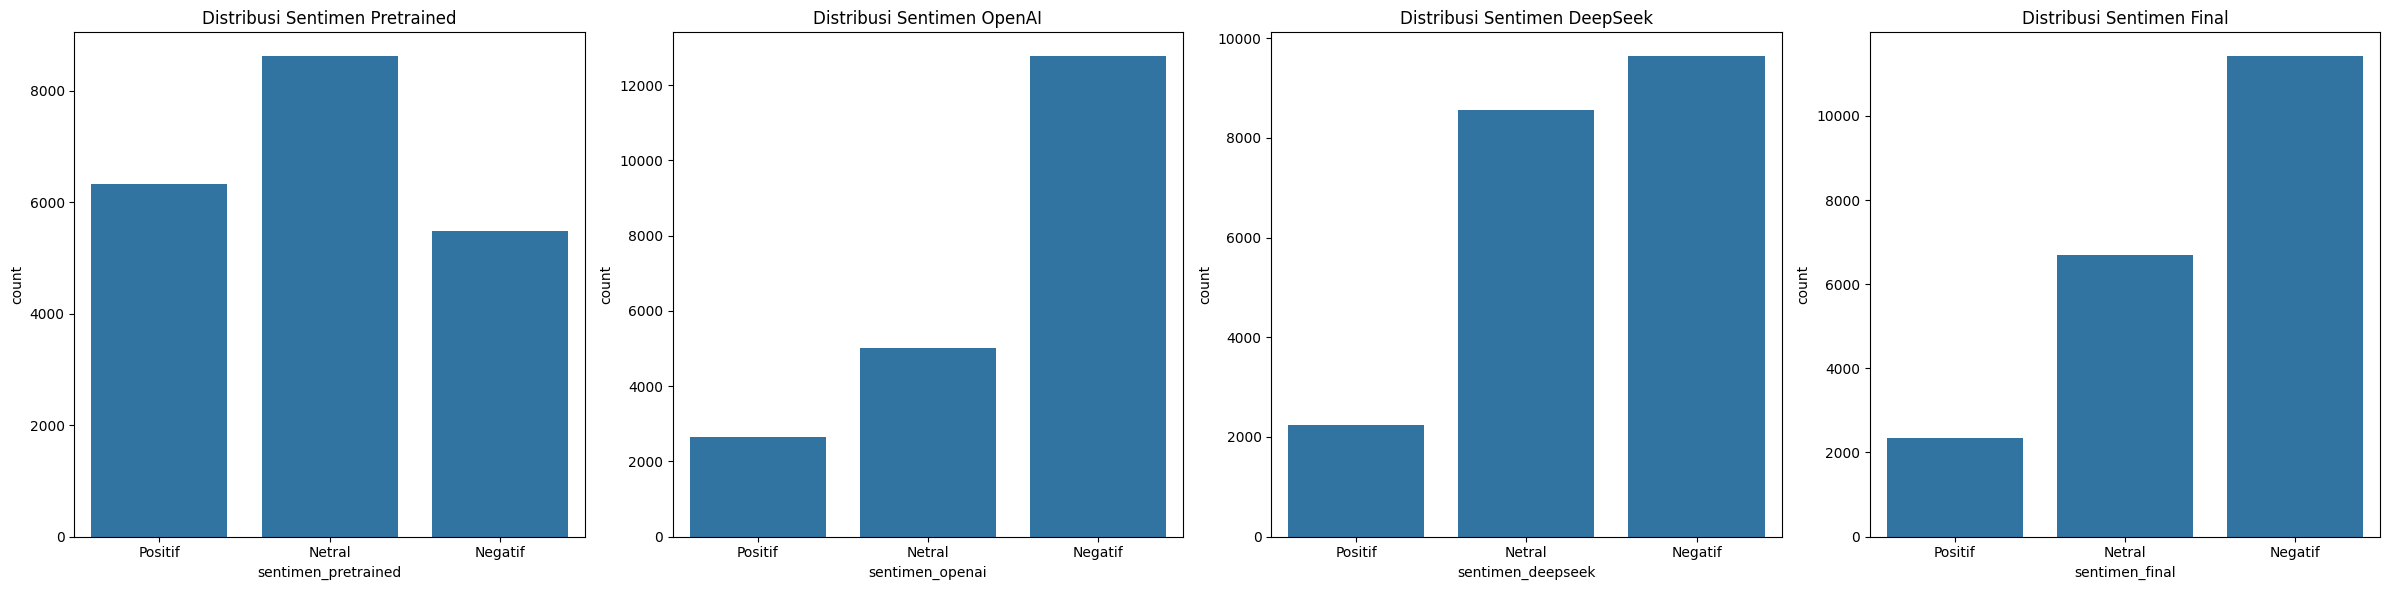


Distribusi Sentimen DeepSeek(%):
Positif: 2242 komentar (10.92%)
Netral: 8565 komentar (41.70%)
Negatif: 9635 komentar (46.91%)

Distribusi Sentimen Pretrained(%):
Positif: 6328 komentar (30.81%)
Netral: 8621 komentar (41.98%)
Negatif: 5494 komentar (26.75%)

Distribusi Sentimen OpenAI(%):
Positif: 2657 komentar (12.94%)
Netral: 5020 komentar (24.44%)
Negatif: 12766 komentar (62.16%)

Distribusi Sentimen Final(%):
Positif: 2334 komentar (11.36%)
Netral: 6693 komentar (32.59%)
Negatif: 11416 komentar (55.58%)

File top 5 postingan telah dibuat: top5_postingan.txt


In [ ]:
# @title **Visualisasi Hasil, Distribusi Sentimen, dan Top 5 Postingan Berdasarkan Sentimen Final**

import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, files
from tqdm.notebook import tqdm

# Mount Google Drive dan pastikan folder output ada
drive.mount('/content/drive')
output_folder = '/content/drive/My Drive/Sentimen IG'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def visualize_and_generate_top5():
    while True:
        print("\nSilakan pilih opsi berikut:")
        print("1. Unggah file CSV")
        print("2. Pilih file CSV yang sudah ada di lingkungan Colab")
        print("3. Batalkan proses")

        choice = input("\nMasukkan pilihan Anda (1/2/3): ").strip()

        if choice == '1':
            print("\nSilakan unggah file CSV yang ingin divisualisasikan:")
            uploaded = files.upload()
            if not uploaded:
                print("Tidak ada file yang diunggah! Silakan coba lagi.")
                continue
            selected_files = list(uploaded.keys())
            break
        elif choice == '2':
            csv_files = glob.glob('*sentimen*.csv')
            if not csv_files:
                print("\nTidak ada file CSV yang valid di lingkungan kerja. Silakan unggah file terlebih dahulu.")
                continue
            print("\nFile CSV yang tersedia:")
            for idx, file in enumerate(csv_files):
                print(f"{idx+1}. {file}")
            file_choice = input("\nMasukkan nomor file yang ingin divisualisasikan (pisahkan dengan koma jika lebih dari satu): ").strip()
            selected_indices = [int(idx.strip()) - 1 for idx in file_choice.split(",") if idx.strip().isdigit()]
            selected_files = [csv_files[idx] for idx in selected_indices if 0 <= idx < len(csv_files)]
            if not selected_files:
                print("Tidak ada file yang dipilih. Silakan coba lagi.")
                continue
            break
        elif choice == '3':
            print("Proses dibatalkan oleh pengguna.")
            return
        else:
            print("Pilihan tidak valid. Silakan masukkan 1, 2, atau 3.")
            continue

    # Gabungkan data dari semua file CSV yang dipilih
    all_dfs = []
    for filename in selected_files:
        try:
            df = pd.read_csv(filename)
            print(f"\nKolom yang tersedia dalam file {filename}: {df.columns.tolist()}")
            required = ['sentimen_pretrained', 'sentimen_openai', 'sentimen_final']
            if not all(col in df.columns for col in required):
                print(f"File {filename} tidak memiliki kolom yang diperlukan. Lewati file ini.")
                continue
            if 'shortlink' not in df.columns:
                # Jika kolom "shortlink" tidak ada, tambahkan dengan mengekstrak dari nama file
                df['shortlink'] = filename.replace("sentimen_", "").replace(".csv", "")
            all_dfs.append(df)
        except Exception as e:
            print(f"Error membaca file {filename}: {str(e)}")
            continue

    if not all_dfs:
        print("\nTidak ada data yang dapat divisualisasikan.")
        return

    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Visualisasi: Jika ada kolom sentimen_deepseek, tampilkan countplot untuk keempat kolom; jika tidak, tiga kolom.
    if 'sentimen_deepseek' in combined_df.columns:
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
        sns.countplot(ax=axes[0], x='sentimen_pretrained', data=combined_df, order=['Positif', 'Netral', 'Negatif'])
        axes[0].set_title("Distribusi Sentimen Pretrained")
        sns.countplot(ax=axes[1], x='sentimen_openai', data=combined_df, order=['Positif', 'Netral', 'Negatif'])
        axes[1].set_title("Distribusi Sentimen OpenAI")
        sns.countplot(ax=axes[2], x='sentimen_deepseek', data=combined_df, order=['Positif', 'Netral', 'Negatif'])
        axes[2].set_title("Distribusi Sentimen DeepSeek")
        sns.countplot(ax=axes[3], x='sentimen_final', data=combined_df, order=['Positif', 'Netral', 'Negatif'])
        axes[3].set_title("Distribusi Sentimen Final")
        plt.tight_layout()
        plt.show()
    else:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
        sns.countplot(ax=axes[0], x='sentimen_pretrained', data=combined_df, order=['Positif', 'Netral', 'Negatif'])
        axes[0].set_title("Distribusi Sentimen Pretrained")
        sns.countplot(ax=axes[1], x='sentimen_openai', data=combined_df, order=['Positif', 'Netral', 'Negatif'])
        axes[1].set_title("Distribusi Sentimen OpenAI")
        sns.countplot(ax=axes[2], x='sentimen_final', data=combined_df, order=['Positif', 'Netral', 'Negatif'])
        axes[2].set_title("Distribusi Sentimen Final")
        plt.tight_layout()
        plt.show()

    # Menghitung distribusi sentimen untuk masing-masing metode
    total = len(combined_df)
    sentiment_counts_pretrained = combined_df['sentimen_pretrained'].value_counts().reindex(['Positif', 'Netral', 'Negatif'], fill_value=0)
    percentages_pretrained = (sentiment_counts_pretrained / total) * 100

    sentiment_counts_openai = combined_df['sentimen_openai'].value_counts().reindex(['Positif', 'Netral', 'Negatif'], fill_value=0)
    percentages_openai = (sentiment_counts_openai / total) * 100

    sentiment_counts_final = combined_df['sentimen_final'].value_counts().reindex(['Positif', 'Netral', 'Negatif'], fill_value=0)
    percentages_final = (sentiment_counts_final / total) * 100

    if 'sentimen_deepseek' in combined_df.columns:
        sentiment_counts_deepseek = combined_df['sentimen_deepseek'].value_counts().reindex(['Positif', 'Netral', 'Negatif'], fill_value=0)
        percentages_deepseek = (sentiment_counts_deepseek / total) * 100
        print("\nDistribusi Sentimen DeepSeek(%):")
        for sentiment in ['Positif', 'Netral', 'Negatif']:
            print(f"{sentiment}: {sentiment_counts_deepseek[sentiment]} komentar ({percentages_deepseek[sentiment]:.2f}%)")

    print("\nDistribusi Sentimen Pretrained(%):")
    for sentiment in ['Positif', 'Netral', 'Negatif']:
        print(f"{sentiment}: {sentiment_counts_pretrained[sentiment]} komentar ({percentages_pretrained[sentiment]:.2f}%)")

    print("\nDistribusi Sentimen OpenAI(%):")
    for sentiment in ['Positif', 'Netral', 'Negatif']:
        print(f"{sentiment}: {sentiment_counts_openai[sentiment]} komentar ({percentages_openai[sentiment]:.2f}%)")

    print("\nDistribusi Sentimen Final(%):")
    for sentiment in ['Positif', 'Netral', 'Negatif']:
        print(f"{sentiment}: {sentiment_counts_final[sentiment]} komentar ({percentages_final[sentiment]:.2f}%)")

    # Hitung Top 5 Postingan berdasarkan jumlah komentar (berdasarkan sentimen_final)
    grouped = combined_df.groupby("shortlink")["sentimen_final"].value_counts().unstack(fill_value=0)
    if "Positif" not in grouped.columns:
        grouped["Positif"] = 0
    if "Negatif" not in grouped.columns:
        grouped["Negatif"] = 0

    top5_positif = grouped["Positif"].sort_values(ascending=False).head(5)
    top5_negatif = grouped["Negatif"].sort_values(ascending=False).head(5)

    # Tulis hasil top 5 ke dalam file .txt
    top5_filename = "top5_postingan.txt"
    with open(top5_filename, "w", encoding="utf-8") as f:
        f.write("Top 5 Postingan dengan jumlah komentar positif terbanyak\n")
        for i, (shortlink, count) in enumerate(top5_positif.items(), start=1):
            f.write(f"{i}. {shortlink} ({count} komentar positif)\n")
        f.write("\n")
        f.write("Top 5 Postingan dengan jumlah komentar negatif terbanyak\n")
        for i, (shortlink, count) in enumerate(top5_negatif.items(), start=1):
            f.write(f"{i}. {shortlink} ({count} komentar negatif)\n")

    print("\nFile top 5 postingan telah dibuat:", top5_filename)

    download_choice = input("\nUnduh file top5_postingan.txt? (y/n): ").strip().lower()
    if download_choice == 'y':
        files.download(top5_filename)
        print("File top5_postingan.txt sedang diunduh...")
    else:
        print("File top5_postingan.txt tidak diunduh.")

# Jalankan fungsi visualisasi dan pembuatan file top 5
visualize_and_generate_top5()



---



---



---

